In [74]:
import pandas as pd 
import numpy as np
import datetime
import os
import logging
import joblib
from typing import Union
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report


In [86]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

df_train.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,Promoted_or_Not
0,YAK/S/00001,Commercial Sales and Marketing,"MSc, MBA and PhD",Female,Direct Internal process,2,1986,12.5,2011,1,0,41,ANAMBRA,No,Married,No,No,0,0
1,YAK/S/00002,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1991,12.5,2015,0,0,52,ANAMBRA,Yes,Married,No,No,0,0
2,YAK/S/00003,Commercial Sales and Marketing,First Degree or HND,Male,Direct Internal process,2,1987,7.5,2012,0,0,42,KATSINA,Yes,Married,No,No,0,0
3,YAK/S/00004,Commercial Sales and Marketing,First Degree or HND,Male,Agency and others,3,1982,2.5,2009,0,0,42,NIGER,Yes,Single,No,No,1,0
4,YAK/S/00006,Information and Strategy,First Degree or HND,Male,Direct Internal process,3,1990,7.5,2012,0,0,77,AKWA IBOM,Yes,Married,No,No,1,0


In [21]:
df_test.columns

Index(['EmployeeNo', 'Division', 'Qualification', 'Gender',
       'Channel_of_Recruitment', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'State_Of_Origin',
       'Foreign_schooled', 'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers'],
      dtype='object')

In [22]:
df_train['Promoted_or_Not'].value_counts()

Promoted_or_Not
0    35071
1     3241
Name: count, dtype: int64

In [23]:
count = df_train.groupby(['Qualification', 'Promoted_or_Not']).size().unstack(fill_value=0)

count

Promoted_or_Not,0,1
Qualification,,
First Degree or HND,23483,2095
"MSc, MBA and PhD",9457,1012
Non-University Education,534,52


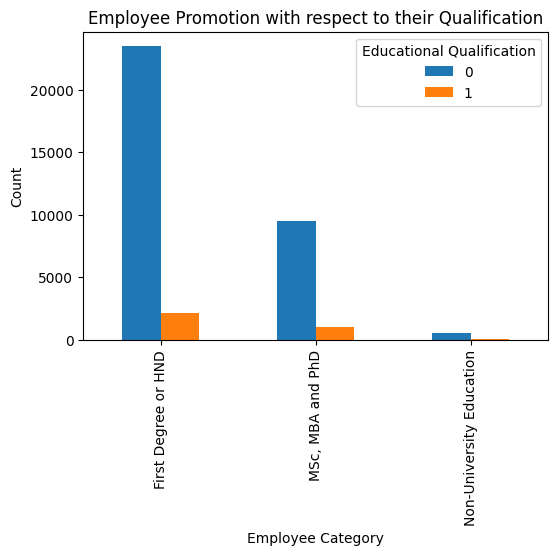

In [24]:
fig, ax = plt.subplots(figsize = (6, 4))

count.plot(
    kind="bar",
    stacked=False,
    ax=ax
)

plt.title("Employee Promotion with respect to their Qualification")
plt.xlabel("Employee Category")
plt.ylabel("Count")
plt.legend(title = "Educational Qualification")
plt.show()

In [25]:
count = df_train.groupby(['Division', 'Promoted_or_Not']).size().unstack(fill_value=0)

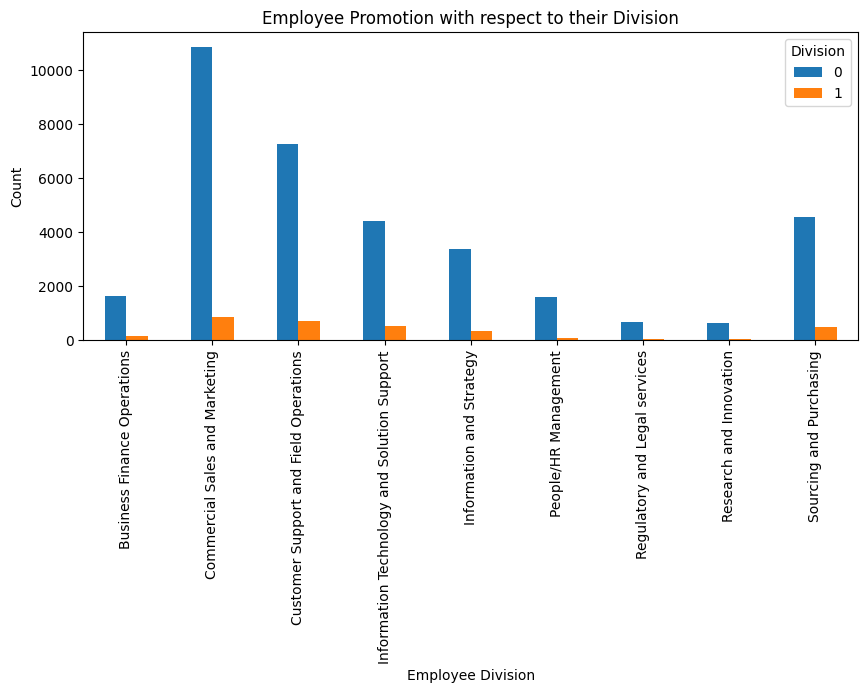

In [26]:
fig, ax = plt.subplots(figsize = (10, 4))

count.plot(
    kind="bar",
    stacked=False,
    ax=ax
)

plt.title("Employee Promotion with respect to their Division")
plt.xlabel("Employee Division")
plt.ylabel("Count")
plt.legend(title = "Division")
plt.show()

In [27]:
# categorical columns

cat_col = [col for col in df_train.columns if df_train[col].dtype == "O" and col != "EmployeeNo"]

In [28]:
cat_col

['Division',
 'Qualification',
 'Gender',
 'Channel_of_Recruitment',
 'State_Of_Origin',
 'Foreign_schooled',
 'Marital_Status',
 'Past_Disciplinary_Action',
 'Previous_IntraDepartmental_Movement',
 'No_of_previous_employers']

In [29]:
for col in df_train[cat_col]:
    if col != "EmployeeNo":
        print(f"Number of unique categories: {df_train[col].nunique()}")
        print(f"{col}: {df_train[col].unique()}")
        print("\n")

Number of unique categories: 9
Division: ['Commercial Sales and Marketing' 'Customer Support and Field Operations'
 'Information and Strategy' 'Information Technology and Solution Support'
 'Sourcing and Purchasing' 'Business Finance Operations'
 'People/HR Management' 'Research and Innovation'
 'Regulatory and Legal services']


Number of unique categories: 3
Qualification: ['MSc, MBA and PhD' 'First Degree or HND' nan 'Non-University Education']


Number of unique categories: 2
Gender: ['Female' 'Male']


Number of unique categories: 3
Channel_of_Recruitment: ['Direct Internal process' 'Agency and others'
 'Referral and Special candidates']


Number of unique categories: 37
State_Of_Origin: ['ANAMBRA' 'KATSINA' 'NIGER' 'AKWA IBOM' 'ENUGU' 'OYO' 'LAGOS' 'ONDO'
 'KWARA' 'EDO' 'BAUCHI' 'TARABA' 'RIVERS' 'KADUNA' 'PLATEAU' 'EKITI'
 'BORNO' 'IMO' 'CROSS RIVER' 'KANO' 'FCT' 'OGUN' 'GOMBE' 'DELTA' 'BENUE'
 'ZAMFARA' 'OSUN' 'ABIA' 'KEBBI' 'ADAMAWA' 'NASSARAWA' 'SOKOTO' 'KOGI'
 'JIGAWA' 'BAYE

## Handling Categorical Variables

In [69]:
def encode_columns(train_df, columns):
    encoders = {}
    for column in columns:
        encoder = LabelEncoder()
        # NOTE: I am fitting on the train data and I am transform on the test data 
        # this is to prevent data leakage, ensures the model's ability to generalize,
        #  maintains consistency in encoding, and handles unseen categories appropriately.
        train_df[column + '_encoded'] = encoder.fit_transform(train_df[column])
        encoders[column] = encoder
        logging.info("Persisting encoding")
        joblib.dump(encoders, 'encoder.joblib')
        logging.info("Persisting encoding completed...")

    return train_df, encoders

In [73]:

df_train, encoders = encode_columns(df_train, cat_col)



In [32]:
# drop the original columns
df_train.drop(columns=cat_col, axis=1, inplace=True)
df_test.drop(columns=cat_col, axis=1, inplace=True)

In [33]:
df_train.columns

Index(['EmployeeNo', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Promoted_or_Not',
       'Division_encoded', 'Qualification_encoded', 'Gender_encoded',
       'Channel_of_Recruitment_encoded', 'State_Of_Origin_encoded',
       'Foreign_schooled_encoded', 'Marital_Status_encoded',
       'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded'],
      dtype='object')

In [35]:
df_train.columns

Index(['EmployeeNo', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Promoted_or_Not',
       'Division_encoded', 'Qualification_encoded', 'Gender_encoded',
       'Channel_of_Recruitment_encoded', 'State_Of_Origin_encoded',
       'Foreign_schooled_encoded', 'Marital_Status_encoded',
       'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded'],
      dtype='object')

In [36]:
df_train.head()

,EmployeeNo,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not,Division_encoded,Qualification_encoded,Gender_encoded,Channel_of_Recruitment_encoded,State_Of_Origin_encoded,Foreign_schooled_encoded,Marital_Status_encoded,Past_Disciplinary_Action_encoded,Previous_IntraDepartmental_Movement_encoded,No_of_previous_employers_encoded
0,YAK/S/00001,2,1986,12.5,2011,1,0,41,0,1,1,0,1,3,0,0,0,0,0
1,YAK/S/00002,2,1991,12.5,2015,0,0,52,0,2,0,1,0,3,1,0,0,0,0
2,YAK/S/00003,2,1987,7.5,2012,0,0,42,0,1,0,1,1,20,1,0,0,0,0
3,YAK/S/00004,3,1982,2.5,2009,0,0,42,0,1,0,1,0,26,1,2,0,0,1
4,YAK/S/00006,3,1990,7.5,2012,0,0,77,0,4,0,1,1,2,1,0,0,0,1


In [37]:
df_train.dtypes

EmployeeNo                                      object
Trainings_Attended                               int64
Year_of_birth                                    int64
Last_performance_score                         float64
Year_of_recruitment                              int64
Targets_met                                      int64
Previous_Award                                   int64
Training_score_average                           int64
Promoted_or_Not                                  int64
Division_encoded                                 int64
Qualification_encoded                            int64
Gender_encoded                                   int64
Channel_of_Recruitment_encoded                   int64
State_Of_Origin_encoded                          int64
Foreign_schooled_encoded                         int64
Marital_Status_encoded                           int64
Past_Disciplinary_Action_encoded                 int64
Previous_IntraDepartmental_Movement_encoded      int64
No_of_prev

In [38]:
print(df_train['Year_of_birth'].max())
print(df_train['Year_of_birth'].min())

2001
1950


In [39]:
df_train.columns

Index(['EmployeeNo', 'Trainings_Attended', 'Year_of_birth',
       'Last_performance_score', 'Year_of_recruitment', 'Targets_met',
       'Previous_Award', 'Training_score_average', 'Promoted_or_Not',
       'Division_encoded', 'Qualification_encoded', 'Gender_encoded',
       'Channel_of_Recruitment_encoded', 'State_Of_Origin_encoded',
       'Foreign_schooled_encoded', 'Marital_Status_encoded',
       'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded'],
      dtype='object')

In [41]:


def calculate_years(year):

    year = datetime.datetime.strptime(str(year), "%Y")

    # I used 2019 because this data was produced in 2019
    year = datetime.datetime.strptime(str("2019"), "%Y") - year

    years =  year.days // 365

    return years


In [42]:
calculate_years("2017")

2

In [43]:
df_train['age'] = df_train['Year_of_birth'].apply(calculate_years)
df_train['no_of_years_in_the_company'] = df_train['Year_of_recruitment'].apply(calculate_years)

In [44]:
df_train[['age', 'Year_of_birth', 'no_of_years_in_the_company', 'Year_of_recruitment']]

,age,Year_of_birth,no_of_years_in_the_company,Year_of_recruitment
0,33,1986,8,2011
1,28,1991,4,2015
2,32,1987,7,2012
3,37,1982,10,2009
4,29,1990,7,2012
...,...,...,...,...
38307,29,1990,1,2018
38308,35,1984,6,2013
38309,25,1994,3,2016
38310,27,1992,2,2017


In [45]:
df_train.drop(columns=['Year_of_birth', 'Year_of_recruitment'], inplace=True)

In [46]:
df_train.columns

Index(['EmployeeNo', 'Trainings_Attended', 'Last_performance_score',
       'Targets_met', 'Previous_Award', 'Training_score_average',
       'Promoted_or_Not', 'Division_encoded', 'Qualification_encoded',
       'Gender_encoded', 'Channel_of_Recruitment_encoded',
       'State_Of_Origin_encoded', 'Foreign_schooled_encoded',
       'Marital_Status_encoded', 'Past_Disciplinary_Action_encoded',
       'Previous_IntraDepartmental_Movement_encoded',
       'No_of_previous_employers_encoded', 'age',
       'no_of_years_in_the_company'],
      dtype='object')

In [47]:
# confirm that all the columns are now int and float respectively

b = [col for col in df_train.columns if df_train[col].dtypes == "O" and col != "EmployeeNo"]

b

[]

In [48]:
df_train.head()

,EmployeeNo,Trainings_Attended,Last_performance_score,Targets_met,Previous_Award,Training_score_average,Promoted_or_Not,Division_encoded,Qualification_encoded,Gender_encoded,Channel_of_Recruitment_encoded,State_Of_Origin_encoded,Foreign_schooled_encoded,Marital_Status_encoded,Past_Disciplinary_Action_encoded,Previous_IntraDepartmental_Movement_encoded,No_of_previous_employers_encoded,age,no_of_years_in_the_company
0,YAK/S/00001,2,12.5,1,0,41,0,1,1,0,1,3,0,0,0,0,0,33,8
1,YAK/S/00002,2,12.5,0,0,52,0,2,0,1,0,3,1,0,0,0,0,28,4
2,YAK/S/00003,2,7.5,0,0,42,0,1,0,1,1,20,1,0,0,0,0,32,7
3,YAK/S/00004,3,2.5,0,0,42,0,1,0,1,0,26,1,2,0,0,1,37,10
4,YAK/S/00006,3,7.5,0,0,77,0,4,0,1,1,2,1,0,0,0,1,29,7


## Modelling

In [49]:
# define dependent and independent varaibles

X = df_train.drop(columns=['EmployeeNo', "Promoted_or_Not"], axis = 1)
y = df_train['Promoted_or_Not']



In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=33
)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7015
           1       0.43      0.42      0.42       648

    accuracy                           0.90      7663
   macro avg       0.69      0.68      0.68      7663
weighted avg       0.90      0.90      0.90      7663

Accuracy: 0.9030405846274305
Confusion Matrix:
[[6650  365]
 [ 378  270]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7015
           1       0.43      0.42      0.42       648

    accuracy                           0.90      7663
   macro avg       0.69      0.68      0.68      7663
weighted avg       0.90      0.90      0.90      7663

F1 Score: 0.4208885424785659
Precision: 0.4251968503937008
Recall: 0.4166666666666667
AUC: 0.8569099064614626


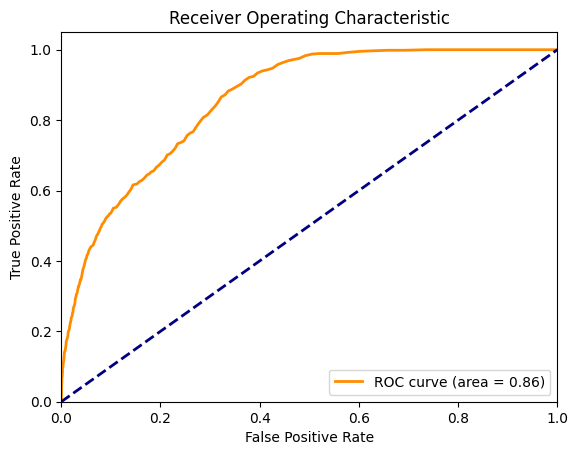

In [51]:


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resample the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Define the model and parameter grid
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1', cv=5)
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [52]:


joblib.dump(best_model, 'model_0.0.1.joblib', compress = 3)

['model_0.0.1.joblib']

In [65]:

def get_file_size(file_path):
    
    file_size = os.path.getsize(file_path)


    file_size_mb = file_size / (1024 * 1024)

    print(f"File size is {round(file_size_mb, 2)} mb")

In [66]:
get_file_size("model_0.0.1.joblib")

File size is 32.25 mb


In [63]:

joblib.dump(best_model, 'model_0.0.2.joblib')

['model_0.0.2.joblib']

In [67]:
get_file_size("model_0.0.2.joblib")

File size is 185.49 mb


## Predict on test data

In [77]:
def custom_label_encoder(X, columns):
    encoders = {}
    X_encoded = X.copy()
    logging.info("Encoding begins...")
    for column in columns:
        encoder = LabelEncoder()
        X_encoded[column + '_encoded'] = encoder.fit_transform(X[column])
        encoders[column] = encoder
    logging.info("Encoding completed...")
    X_encoded.drop(columns=columns, inplace=True)
    logging.info("Persisting encoding")
    joblib.dump(encoders, 'encoder.joblib')
    logging.info("Persisting encoding completed...")
    return X_encoded, encoders

def calculate_years(year):
    year = datetime.datetime.strptime(str(year), "%Y")
    years = datetime.datetime.strptime("2019", "%Y") - year
    return years.days // 365

def add_age_and_experience(X):
    X = X.copy()
    X['age'] = X['Year_of_birth'].apply(calculate_years)
    X['no_of_years_in_the_company'] = X['Year_of_recruitment'].apply(calculate_years)
    X.drop(columns=['Year_of_birth', 'Year_of_recruitment'], inplace=True)
    return X

def preprocess_data(X, cat_columns):
    X_encoded, encoders = custom_label_encoder(X, cat_columns)
    X_final = add_age_and_experience(X_encoded)
    return X_final, encoders


def load_model(model_path: str):
    return joblib.load(model_path)

def load_encoders(encoders_path: str):
    return joblib.load(encoders_path)

def apply_encoders(X, encoders):
    X_encoded = X.copy()
    for column, encoder in encoders.items():
        X_encoded[column + '_encoded'] = X[column].apply(
            lambda x: encoder.transform([x])[0] if x in encoder.classes_ else -1
        )
    X_encoded.drop(columns=encoders.keys(), inplace=True)
    return X_encoded





In [87]:
def predict_staff_promotion(input_data: 
                    Union[pd.DataFrame, dict]) -> dict:
        
        # input_df = pd.DataFrame(input_data, index=[0])

        relevant_data = input_data.drop(columns=['EmployeeNo'],axis =1)

        print(relevant_data.columns)

        encoders = load_encoders("encoder.joblib")
        model = load_model("model_0.0.1.joblib")

        relevant_data_encoded = apply_encoders(relevant_data, encoders)
        
        relevant_data_final = add_age_and_experience(relevant_data_encoded)
        
        # Make predictions
        predictions = model.predict(relevant_data_final)[0]
        predictions_prob = model.predict_proba(relevant_data_final)[:, 1]

        return predictions, predictions_prob

In [88]:
predictions, predictions_prob = predict_staff_promotion(df_test)

Index(['Division', 'Qualification', 'Gender', 'Channel_of_Recruitment',
       'Trainings_Attended', 'Year_of_birth', 'Last_performance_score',
       'Year_of_recruitment', 'Targets_met', 'Previous_Award',
       'Training_score_average', 'State_Of_Origin', 'Foreign_schooled',
       'Marital_Status', 'Past_Disciplinary_Action',
       'Previous_IntraDepartmental_Movement', 'No_of_previous_employers'],
      dtype='object')


In [90]:
df_test['prediction'] = predictions
df_test['prediction_proba'] = predictions_prob

In [91]:
df_test.head()

,EmployeeNo,Division,Qualification,Gender,Channel_of_Recruitment,Trainings_Attended,Year_of_birth,Last_performance_score,Year_of_recruitment,Targets_met,Previous_Award,Training_score_average,State_Of_Origin,Foreign_schooled,Marital_Status,Past_Disciplinary_Action,Previous_IntraDepartmental_Movement,No_of_previous_employers,prediction,prediction_proba
0,YAK/S/00005,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1976,7.5,2017,0,0,65,FCT,Yes,Married,No,No,1,0,0.220
1,YAK/S/00011,Information Technology and Solution Support,NaN,Male,Direct Internal process,2,1991,0.0,2018,0,0,69,OGUN,Yes,Married,No,No,1,0,0.075
2,YAK/S/00015,Research and Innovation,"MSc, MBA and PhD",Male,Direct Internal process,2,1984,7.5,2012,0,0,76,KANO,Yes,Married,No,No,1,0,0.125
3,YAK/S/00016,Customer Support and Field Operations,First Degree or HND,Male,Agency and others,2,1984,2.5,2009,0,0,52,RIVERS,No,Single,No,No,1,0,0.025
4,YAK/S/00017,Information Technology and Solution Support,First Degree or HND,Male,Agency and others,2,1983,7.5,2014,1,0,69,FCT,Yes,Married,No,No,0,0,0.615
